# **Redes Neurais - Caso Iris**

Este notebook contém a implementação de uma rede neural escrita explicitamente, que foi apresentado no trabalho da disciplina de Estatística Multivariável da EEL-USP. Aqui serão apresentados todos os processos que envolvem o aprendizado de uma rede artificial, bem como os conceitos mais importantes.

A implementação foi feita em linguagem `R`, de forma que ao longo do notebook serão apresentadas algumas funções e detalhes do código para aqueles que não estão familiarizados. 

---

## **Importação e tratamento dos dados**

Neste notebook utilizaremos o dataset [iris](https://archive.ics.uci.edu/ml/datasets/iris) como exemplo. Ele relaciona o comprimento e a largura de sépalas e pétalas de diversas flores de íris, e classifica-as entre três classes: **setosa**, **versicolor** e **virginica**. 

Iniciaremos importando os pacotes `pracma` e `datasets`, usados para realizar operações vetoriais e para importação de bases de código aberto, respectivamente.

In [2]:
library("pracma")
library("datasets")

Para importar o dataset, basta entrar o comando `datasets::iris`.

In [3]:
data <- datasets::iris
head(data)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


Para usar esta base, se faz necessário normalizar as colunas numéricas e transformar a coluna `Species` em `factor`. A normalização escalar pode ser feita com a função `scale()`.

In [4]:
data$Species = factor(data$Species)

In [5]:
data$Sepal.Length = scale(data$Sepal.Length)
data$Sepal.Width = scale(data$Sepal.Width)
data$Petal.Length = scale(data$Petal.Length)
data$Petal.Width = scale(data$Petal.Width)

Definiremos também a função `train_test_split` para separar a base em sets de treinamento e de teste, certificando que as classes sejam distribuidas de forma proporcional em ambos os sets. A sintaxe para a definição de uma função no R é:

``` R
nome_da_funcao = function(
    varivel_1,
    varivel_2
    # ...
){
    # argumento da função
}
```

In [6]:
train_test_split = function(data, train_fraction = 0.8, train = TRUE) {
    unique_targets = unlist(unique(data[5]))
    len_unique = length(unique_targets) 
    
    for (i in 1:len_unique) {
        unique_data = subset(data, data[5] == as.character(unique_targets)[i])
        
        total_rows = nrow(unique_data)
        train_rows = train_fraction * total_rows
        sample = 1:train_rows
        if (train == TRUE) {
            dataset = unique_data[sample, ]
        } else {
            dataset = unique_data[-sample, ]
        }
        
        if (i == 1) {
            data_out = dataset
        }
        else {
            data_out = rbind(data_out, dataset)
        }
        
    }
    
    return(data_out)
}

In [7]:
train <- train_test_split(data, 0.8, train = TRUE)
test <- train_test_split(data, 0.8, train = FALSE)

---

## **Rede artificial**

Uma rede neural consiste de dois processos básicos, chamados _feedforward_ e _backpropagation_. O processo de _feedforward_ consiste em alimentar os neurônios subsequentes da rede com informações que, após serem avaliadas através de uma função, chegam finalmente ao último neurônio, gerando o output das operações. Já o processo de _backpropagation_ consiste em atualizar os pesos que estão associados a cada neurônio através de um algoritmo de otimização, com a finalidade de reajustar o modelo para gerar melhores resultados. 

Um modelo simples de rede neural é aquele que consegue classificar uma instância entre duas classes, ou seja, uma *classificação binária*. Como este dataset possui três classes como variável resposta, buscaremos responder à pergunta "*Esta flor pertence à classe X?*"
Para tal, definiremos a função `distinguir(objeto, coluna)` que substitui os valores de classe para 0 ou 1.

In [8]:
unique(train['Species'])

,Species
,<fct>
1,setosa
51,versicolor
101,virginica


In [9]:
distinguir = function(objeto, coluna) {
    y = vector()
    for (i in 1:nrow(coluna)) {
        if (coluna[i, 1] == objeto) {
            y[i] = 1
        }
        else {
            y[i] = 0
        }
    }
    
    return (y)
}

In [10]:
input <- train[c(0:4)]
output_setosa = distinguir('setosa', train[5])

In [11]:
output_setosa

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [75] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[112] 0 0 0 0 0 0 0 0 0

Com isso podemos programar uma rede neural. O primeiro passo a se fazer é iniciar o processo de feedforward, o qual se baseia em uma operação matricial entre dois vetores: um vetor de parâmetros e um de pesos. O vetor de parâmetros toma os valores de entrada, que no nosso caso são as variáveis `Sepal.Lenght`, `Sepal.Width`, `Petal.Lenght` e `Petal.Width`. Chamando a i-ésima variável de $x_i$, temos uma operação linear dada por
$$
k(X, W) = x_1w_1+x_2w_2+x_3x_3+x_4w_4 = WX
$$
onde $X$ é o vetor $(x_1, x_2, x_3, x_4)$ e $W$$ = (w_1, w_2, w_3, w_4)$. O resultado desta função passa então por uma função chamada *função de ativação* $f(x)$, de forma que o resultado final do neurônio de saída é 
$$
\hat{y} = f(k(x))
$$

Existem diversas funções de ativação, como a sigmoide, tangente hiperbólico, a ReLu, etc. Estas funções são usadas para introduzir [novos niveis de dimensionalidade nas redes](https://matheusfacure.github.io/2017/07/12/activ-func/), de forma que elas não sejam puramente operações lineares, tornando-as mais capacitadas a entenderem padrões complexos. A função que usaremos neste exemplo é a função de ativação **sigmoide**, que é dada pela função
$$
\sigma(x) = \dfrac{1}{1+e^{-x}}
$$
<center>
<img src="figuras/Logistic-curve.png">
</center>
Para a finalidade de otimização da rede, definiremos uma função para a função  sigmoid e também para a sua derivada, que é dada por $d\sigma(x)/dx = \sigma(x)(1-\sigma(x))$:

In [12]:
logistic = function(x){
    return (1.0/(1 + exp(-x)))
}

logistic_deriv = function(x){
    return (logistic(x)*(1-logistic(x)))
}

O processo de aprendizado de uma rede é baseado nos valores que os pesos $W$ possuem. Inicialmente, os valores destes pesos podem ser escolhidos aleatóriamente, o que pode ser realizado com a função `runif` que gera números aleatórios baseado na distribuição uniforme. Por finalidade de reprodutibilidade, é recomendável configurar um valor de semente (`seed`). Nos exemplos aqui apresentados tal valor será se $40$.

Como o vetor de entrada possui $4$ dimensões, $W$ deve possuir também quatro dimensões. Chamaremos aqui o vetor $W$ de `weight_ItoO`, pois é o peso que é operado sobre os inputs, levando ao diretamente aos outputs.

In [13]:
set.seed(40)

weight_ItoO <- runif(4)
weight_ItoO

[1] 0.6835820 0.8729038 0.6901173 0.1159361

Com isso é possível realizar o produto interno entre os valores dos atributos com os pesos gerados aleatóriamente.

In [14]:
print('Produto interno entre os atributos e pesos da primeira instância: ')
dot(unlist(input[1, ]), weight_ItoO)
print('Produto interno com a função de ativação: ')
logistic(dot(unlist(input[1, ]), weight_ItoO))

[1] "Produto interno entre os atributos e pesos da primeira instância: "


[1] -0.8009344

[1] "Produto interno com a função de ativação: "


[1] 0.3098257

Assim, com os pesos aleatoriamente gerados o modelo inicial previu que a primeira flor contida no set `input` seria uma flor da espécie setosa. Obviamente este resultado não é confiável, pois ele foi gerado aleatóriamente e ainda não foi comparado com nenhum resultado real para validar a sua predição. Para que o processo de aprendizado ocorra, se faz necessário iniciar o processo de backpropagation. 

Neste processo deve ser implementado algum algoritmo de otimização. A técnica mais básica e comum em aplicações de aprendizado de máquina é o *gradiente descendente*. Este método consiste em tomar uma função que aponte para alguma métrica de erro, denominada *função custo*, e caminhar no espaço matemático dos pesos rumo ao ponto onde o gradiente desta função assume o menor valor, ou seja, onde a função custo é minima. 

Matematicamente falando, se a predição gerou um valor $\hat{y}_i$, então a [função custo será](https://medium.com/@zeeshanmulla/cost-activation-loss-function-neural-network-deep-learning-what-are-these-91167825a4de) $J = \sum^m_i(1/2)(\hat{y}_i - y_i)^2$. Este valor implica que o processo de backpropagation não se baseia em apenas valores das instâncias, mas sim no que é gerado sobre todo o dataset. Portanto, se faz necessário criar um vetor contento os resultados do feedforward, calculados para cada instância. Chamaremos este vetor de predições de `outputP`.

In [15]:
outputP_pre = vector()
outputP = vector()
for (i in 1:nrow(input)) {
    outputP_pre[i] = dot(unlist(input[i, ]), weight_ItoO) ## pré-ativação
    outputP[i] = logistic(outputP_pre[i]) ## pós-ativação
}

Para a função sigmoid,[o gradiente da função custo é](https://towardsdatascience.com/a-step-by-step-implementation-of-gradient-descent-and-backpropagation-d58bda486110) ([este video](https://www.youtube.com/watch?time_continue=479&v=tIeHLnjs5U8&feature=emb_logo) apresenta uma derivação de tal resultado) 
$$
\dfrac{\partial J(W)}{\partial w_{j}} = (Y-\hat{Y})\dfrac{\partial \sigma(k(X, W))}{\partial w_{j}} X_j
$$
onde $(Y-\hat{Y}) = (y_1 - \hat{y}_1, y_2 - \hat{y}_2, \dots)$, $X_j$ é o vetor coluna contendo todos os valores das instâncias para a j-ésima dimensão (um dos atributos de entrada do dataset) e $\dfrac{\partial \sigma(k(X, W))}{\partial w_{j}}$ é a derivada da função sigmoid, atuando sobre $k(x, w)$, em relação aos pesos. Esta derivada é
$$
\dfrac{\partial \sigma(k(X, W))}{\partial w_{j}} = \sigma(k(X, W))(1 - \sigma(k(X, W)))
$$
ficando claro agora o motivo da função `logistic_deriv` ter sido definida. Portanto, cada componente do vetor gradiente é resultado de um produto interno entre o vetor $X_j$ e $\sigma(k(X, W))(1 - \sigma(k(X, W))) (Y-\hat{Y})$.

Chamando $(Y-\hat{Y})$ de `erro`, $\dfrac{\partial \sigma(k(X, W))}{\partial w_{j}}(Y-\hat{Y})$ de `S_e` e `grad` o vetor das gradiente $\nabla J(W) = \left(\dfrac{\partial J(W)}{\partial w_{1}}, \dfrac{\partial J(W)}{\partial w_{2}}, \dots\right)$, então:

In [16]:
erro = outputP - output_setosa
erro

[1] -0.69017433 -0.87732955 -0.85458703 -0.87821924 -0.66445640 -0.40239501
  [7] -0.80198566 -0.73974840 -0.92958998 -0.85109674 -0.52838162 -0.76326628
 [13] -0.88746880 -0.93055082 -0.33179374 -0.17274348 -0.44050281 -0.68691256
 [19] -0.39468239 -0.53639174 -0.65390929 -0.58197435 -0.76310849 -0.73857233
 [25] -0.74142542 -0.85895561 -0.72614437 -0.66358006 -0.71476727 -0.83939858
 [31] -0.85464127 -0.66463863 -0.37587055 -0.28269085 -0.84915885 -0.82670882
 [37] -0.62476462 -0.68589106 -0.91828220 -0.72354399  0.83744594  0.74669439
 [43]  0.80998655  0.15574806  0.59907913  0.41865509  0.78451483  0.09074792
 [49]  0.65791804  0.23854469  0.04997939  0.53754996  0.17896849  0.57336053
 [55]  0.36298737  0.74538380  0.50502706  0.34343634  0.25223434  0.21812346
 [61]  0.69661107  0.45176102  0.43856224  0.51621600  0.59185670  0.68811504
 [67]  0.67090069  0.76025249  0.53744145  0.23768758  0.16818444  0.16072373
 [73]  0.33274741  0.49982009  0.46381479  0.76252993  0.76970257  0.29454231
 [79]  0.45842493  0.21590803  0.87405290  0.46998788  0.86954620  0.70544440
 [85]  0.79863085  0.92978328  0.17818748  0.87788272  0.61790817  0.96511341
 [91]  0.81369824  0.61142445  0.81651665  0.34815351  0.53895230  0.81987299
 [97]  0.76846049  0.98690534  0.88210767  0.25800440  0.88939925  0.46306625
[103]  0.90798388  0.54962808  0.88986520  0.91478449  0.56900474  0.65359312
[109]  0.69024672  0.86580441  0.85715234  0.98712835  0.69348926  0.60634971
[115]  0.51165063  0.92420272  0.87717690  0.78874143  0.62556238  0.85026108

In [17]:
S_e = erro*logistic_deriv(outputP_pre)
S_e

[1] -0.147582547 -0.094420319 -0.106197854 -0.093925731 -0.148143274
  [6] -0.096765243 -0.127359060 -0.142416884 -0.060843940 -0.107860409
 [11] -0.131669784 -0.137915246 -0.088629673 -0.060137766 -0.073560879
 [16] -0.024685591 -0.108566361 -0.147729953 -0.094292858 -0.133387560
 [21] -0.147987474 -0.141582839 -0.137950115 -0.142605941 -0.142141460
 [26] -0.104063221 -0.144400142 -0.148138650 -0.145723192 -0.113158151
 [31] -0.106171719 -0.148144044 -0.088176179 -0.057323128 -0.108767140
 [36] -0.118435419 -0.146465938 -0.147771466 -0.068907899 -0.144729119
 [41]  0.114001714  0.141231179  0.124663684  0.020479407  0.143888818
 [46]  0.101893534  0.132623261  0.007487859  0.148072279  0.043329524
 [51]  0.002373094  0.133629546  0.026297410  0.140254439  0.083932676
 [56]  0.141463999  0.126244001  0.077440711  0.047574470  0.037199999
 [61]  0.147224631  0.111889008  0.107985163  0.128918256  0.142970293
 [66]  0.147678248  0.148130145  0.138570188  0.133606944  0.043067133
 [71]  0.023528740  0.021680284  0.073878765  0.124955007  0.115346392
 [76]  0.138077421  0.136437882  0.061202102  0.113813853  0.036551448
 [81]  0.096219616  0.117073638  0.098637499  0.146586125  0.128435505
 [86]  0.060702137  0.026093186  0.094113111  0.145886676  0.032494900
 [91]  0.123351293  0.145265029  0.122328246  0.079010879  0.133920332
 [96]  0.121079886  0.136731380  0.012753962  0.091733663  0.049391881
[101]  0.087488622  0.115134892  0.075861282  0.136053316  0.087211350
[106]  0.071310953  0.139541782  0.147979465  0.147579018  0.100595335
[111]  0.104951623  0.012542426  0.147409399  0.144729454  0.127843209
[116]  0.064742296  0.094504924  0.131426712  0.146528034  0.108252840

In [18]:
grad = vector()
for (i in 1:ncol(input)) {
    grad[i] = dot(unlist(input[, i]), S_e)
}
grad

[1]  9.493870 -6.728641 11.730939 11.166058

Com isso a atualização dos pesos será feito baseado na operação 
$$
W^* = W - LR\,\nabla_w J(W) = \left(w_1 - LR \dfrac{\partial J(W)}{\partial w_1}, w_2 - LR \dfrac{\partial J(W)}{\partial w_2}, \dots\right)
$$
sendo $LR$ o fator denominado *learning rate*, ou **fator de aprendizado**. A sua função é indicar qual o tamanho do passo que será tomado rumo o gradiente descentende, ou seja, quanto maior o seu valor, maior será o valor de $LR \dfrac{\partial J(W)}{\partial w_j}$, e portanto maior será a variação no valor de $w_j$. Podemos definir $LR=1$ por finalidade de simplicidade. 

In [19]:
LR = 1
weight_ItoO = weight_ItoO - LR*grad

In [20]:
weight_ItoO

[1]  -8.810288   7.601544 -11.040822 -11.050122

Com isso, realizamos uma iteração que envolve os processos de feedforward e backpropagation. Assim, treinar uma rede neural consiste essencialmente em repetir o mesmo processo, porém agora utilizando os novos pesos. Nesta situação, se torna cômodo definir uma função que realiza tanto o processo de feedforward quanto o de backpropagation retornando sempre os novos valores de peso que serão usados na próxima iteração.

In [21]:
feedforward = function(input, weight_ItoO){
    outputP_pre = vector()
    outputP = vector()
    for (i in 1:nrow(input)) {
        outputP_pre[i] = dot(unlist(input[i, ]), weight_ItoO) ## pré-ativação
        outputP[i] = logistic(outputP_pre[i]) ## pós-ativação
    }
    
    out <- list(outputP, outputP_pre)
    return (out)
}

In [22]:
backpropagation = function(input, output, outputP, outputP_pre, weight_ItoO, LR, print_erro = FALSE){
    erro = outputP - output
    if (print_erro == TRUE){
        print('erro quadrático médio:')
        print(sum(erro^2)/length(erro))
    }

    S_e = erro*logistic_deriv(outputP_pre)

    grad = vector()
    for (i in 1:ncol(input)) {
        grad[i] = dot(unlist(input[, i]), S_e)
    }

    weight_ItoO = weight_ItoO - LR*grad
    
    return(weight_ItoO)
}

In [23]:
new_weights_ItoO = function(input, output, weight_ItoO, LR = 1, print_erro) {
    out = feedforward(input, weight_ItoO)
    outputP = unlist(out[1])
    
    outputP_pre = unlist(out[2])

    weight_ItoO = backpropagation(input, output, outputP, outputP_pre, weight_ItoO, LR, print_erro)
    
    return(weight_ItoO)
}

É possível induzir o processo iterativo para acontecer $N$ vezes. Nos estudos de inteligência artificial, este valor de $N$ é chamado de *epoch*. Definiremos uma variável chamada `epoch` como $10$, onde printaremos o erro quadrático médio $\left(\dfrac{\sum_i(y_i-\hat{y}_i)^2}{n}\right)$.

In [24]:
set.seed(40)
weight_ItoO <- runif(4)

epoch = 15
weights_ItoO = matrix(ncol = 4, nrow = epoch)
for (i in 1:epoch) {
    print(weight_ItoO)
    weight_ItoO = new_weights_ItoO(input, output_setosa, weight_ItoO, LR = 0.6, print_erro = TRUE)
    weights_ItoO[i, ] = weight_ItoO
}
print('pesos finais:')
print(weight_ItoO)

[1] 0.6835820 0.8729038 0.6901173 0.1159361
[1] "erro quadrático médio:"
[1] 0.4513118
[1] -5.012740  4.910088 -6.348446 -6.583699
[1] "erro quadrático médio:"
[1] 0.007688648
[1] -4.909135  5.050807 -6.330267 -6.573476
[1] "erro quadrático médio:"
[1] 0.006793036
[1] -4.796058  5.201613 -6.309693 -6.560429
[1] "erro quadrático médio:"
[1] 0.005760199
[1] -4.676317  5.359234 -6.287439 -6.545205
[1] "erro quadrático médio:"
[1] 0.004650246
[1] -4.557061  5.514621 -6.265212 -6.529486
[1] "erro quadrático médio:"
[1] 0.003605081
[1] -4.447668  5.655726 -6.245238 -6.515529
[1] "erro quadrático médio:"
[1] 0.002768588
[1] -4.354240  5.774775 -6.228986 -6.504882
[1] "erro quadrático médio:"
[1] 0.002180734
[1] -4.277160  5.871478 -6.216597 -6.497782
[1] "erro quadrático médio:"
[1] 0.001790738
[1] -4.213655  5.949662 -6.207461 -6.493698
[1] "erro quadrático médio:"
[1] 0.00153151
[1] -4.160549  6.013635 -6.200857 -6.491968
[1] "erro quadrático médio:"
[1] 0.001353964
[1] -4.115274  6.066874 

Na matriz `weights_ItoO` foram salvos os valores dos pesos para cada iteração. Ao plotar elas, é possível visualizar que existe uma tendência para atingir um valor limite, que é chamado de *plateau*. 

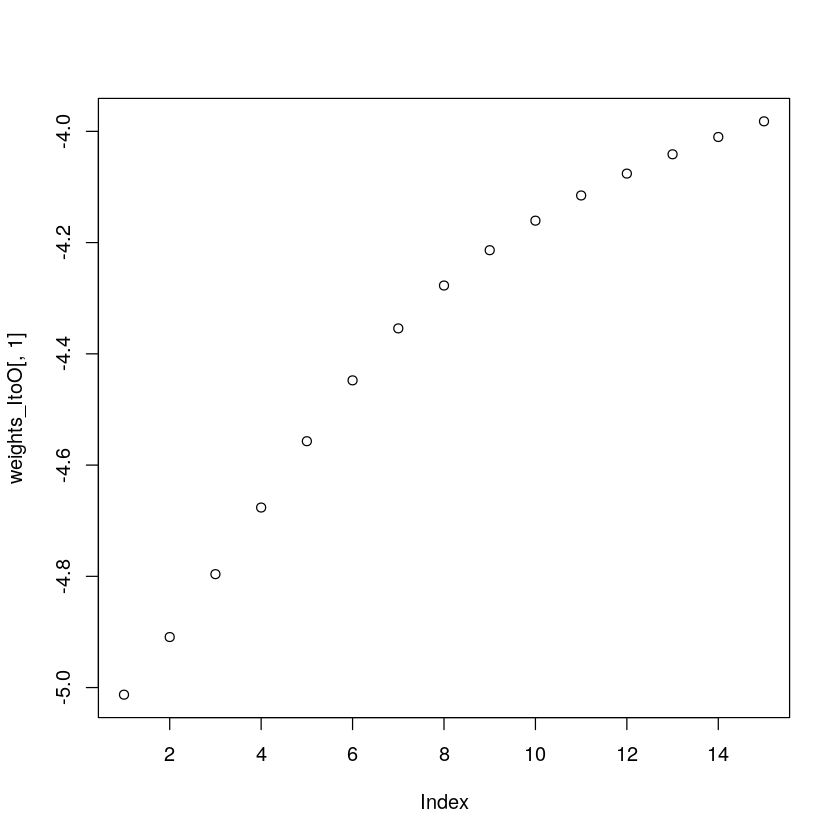

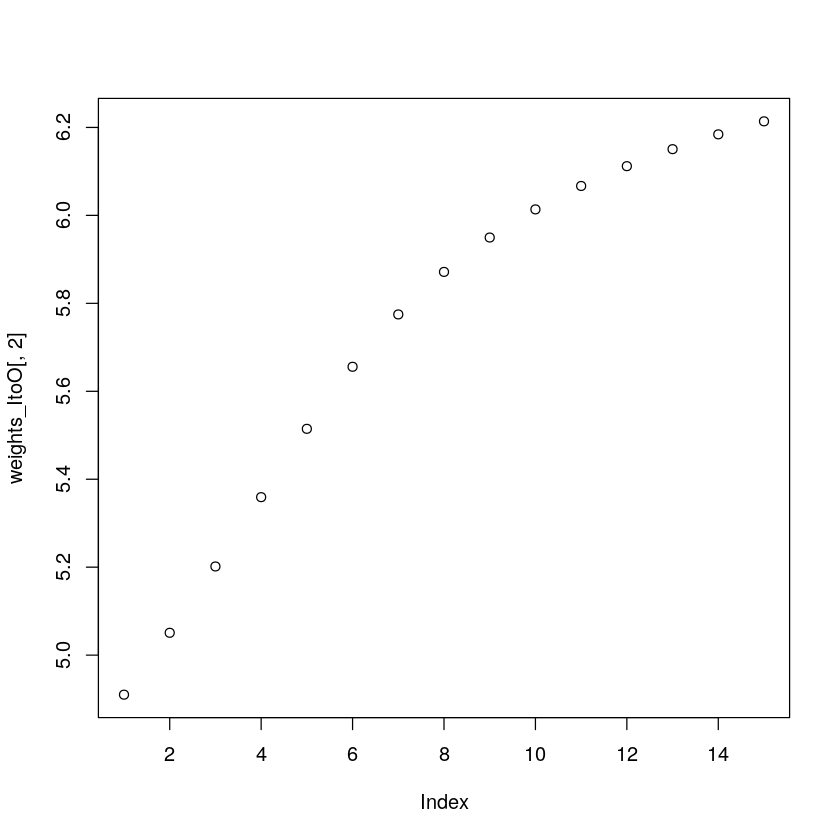

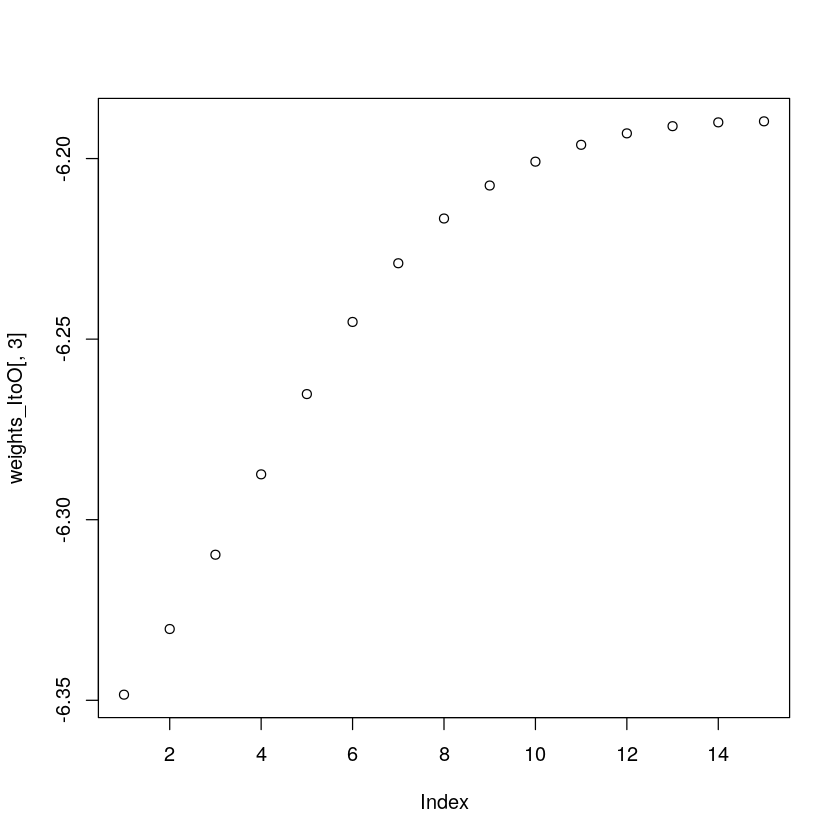

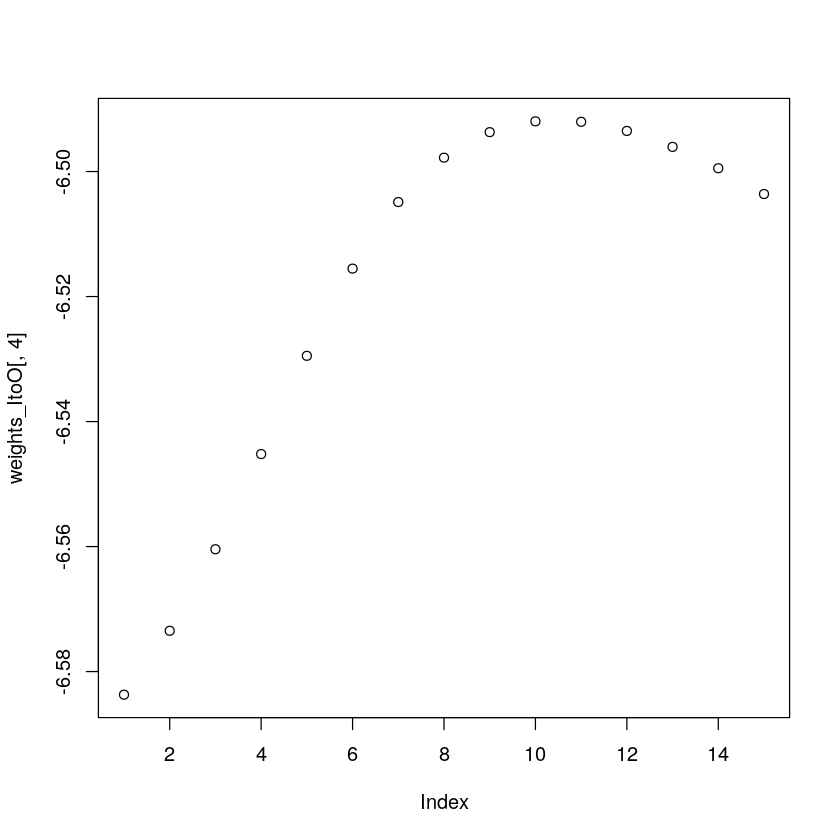

In [25]:
plot(weights_ItoO[, 1])
plot(weights_ItoO[, 2])
plot(weights_ItoO[, 3])
plot(weights_ItoO[, 4])

Como a atualização dos pesos é feita com base no valor do gradiente da função custo, verifica-se que este gradiente possui valores cada vez menores a cada iteração que é feita, o que por sua vez implica em valores de função custo cada vez menores. 

Por fim, o resultado final do modelo é um processo de feedforward realizado sobre os pesos ajustados da rede.

In [26]:
out = feedforward(input, weight_ItoO)

outputP = unlist(out[1])

In [27]:
out_df = data.frame(matrix(c(outputP, output_setosa), nrow=length(outputP)))
names(out_df)[names(out_df) == 'X1'] <- 'Predição pelo modelo'
names(out_df)[names(out_df) == 'X2'] <- 'Valores verdadeiros'
out_df
sum((outputP - output_setosa)^2)/length(outputP)

Predição pelo modelo,Valores verdadeiros
<dbl>,<dbl>
1,1
1,1
1,1
1,1
1,1
1,1
1,1
1,1
1,1


[1] 0.0009638106

É possível averiguar que o modelo já realiza predições razoavelmente boas. Porém, a predição obtida na variável `outputP` foi feita sobre o set de **treinamento**, ou seja, sobre os próprios dados que o modelo utilizou para ser otimizado. Com os pesos obtidos, é possível verificar como será a performance sobre novos dados desconhecidos.

Para tal, definiremos as variáveis `input_test` e `output_setosa_test`, contendo os dados que foram separados anteriormente e que seriam destinados para realizar testes do modelo.

In [28]:
input_test <- test[c(0:4)]
output_setosa_test = distinguir('setosa', test[5])

In [29]:
out_test = feedforward(input_test, weight_ItoO)

outputP_test = unlist(out_test[1])

In [30]:
out_df = data.frame(matrix(c(outputP_test, output_setosa_test), nrow=length(outputP_test)))
names(out_df)[names(out_df) == 'X1'] <- 'Predição pelo modelo'
names(out_df)[names(out_df) == 'X2'] <- 'Valores verdadeiros'
out_df
sum((outputP_test - output_setosa_test)^2)/length(outputP_test)

Predição pelo modelo,Valores verdadeiros
<dbl>,<dbl>
1.000000e+00,1
9.999936e-01,1
1.000000e+00,1
1.000000e+00,1
1.000000e+00,1
1.000000e+00,1
1.000000e+00,1
1.000000e+00,1
1.000000e+00,1


[1] 0.003786859

É possível averiguar que, por mais que o resultado ainda seja razoavelmente bom, o modelo não performa da mesma maneira do que para o set de treinamento. Neste exemplo, esta diferença não invalida a rede, pois por mais que o resultado não seja extamente igual ao caso de treinamento, o modelo ainda é capaz de se generalizar para outros casos. Se esta diferença fosse significativa, o modelo teria de ser reestruturado ou otimizado para generalizar em casos externos ao seu conhecimento (set de treinamento). Este problema é conhecido como ***overfit***, ou seja, quando um algoritmo de inteligência artificial não consegue abstrair as informações de dados desconhecidos tão bem quanto é abstraido dos dados de conhecimento. 

---

## **Rede artificial - multicamadas**

É possível introduzir novos graus de complexidade no modelo através de uso de mais neurônios, de forma que eles se ligam na intercamada entre os neurônios de entrada e os neurônios de saída. Eles são chamados de ***camadas escondidas*** (ou *hidden layers*) e, diferente dos neurônios vizinhos, eles podem assumir um valor indefinido tanto de neurônios quanto de camadas. A sua presença possibilida introduzir novas operações matriciais que são construidas sobre um novo espaço matemático, possibilitando o reconhecimento de padrões não apenas através de sobreposições lineares.  

Se um modelo é construido a partir de $P$ camadas, contendo $L$ neurônios em uma camada $p$, então o valor deste neurônio nesta posíção é
$$
x_{p, l} = f(W_{p-1}^lX_{p-1})
$$
sendo $W_{p-1} = \left(w_{p-1, 1}^l, w_{p-1, 2}^l, \dots w_{p-1, L^*}^l, \right)$ e $X_{p-1} = \left(x_{p-1, 1}, x_{p-1, 2}, \dots , x_{p-1, L^*}\right)$ os pesos e os valores dos neurônios na camada anterior, respectivamente, possuindo $L^*$ neurônios esta camada. Por exemplo, se fossemos contruir uma rede com duas dimensões de entrada, dois neurônios em uma única camada e um último neurônio de saída, o último neurônio teria o valor:

$$
\hat{y} = x_{3, 1} = f(W_2^1X_2) = f(w_{2, 1}^1x_{2, 1} + w_{2, 2}^1x_{2, 2}) = f(w_{2, 1}^1f(W_{1}^1X_{1}) + w_{2, 2}^1f(W_{1}^2X_{1})) = \\
f(w_{2, 1}^1f(w_{1, 1}^1x_{1, 1}+w_{1, 2}^1x_{1, 2}) + w_{2, 2}^1f(w_{1, 1}^2x_{1, 1}+w_{1, 2}^2x_{1, 2}))
$$

Por mais complicado que pareça, a introdução de novas camadas em uma rede implica essencialmente em realizar mais operações que já foram discutidas anteriormente: para cada neurônio da camada subsequente, é realizado uma sobreposição linear entre os pesos associados à este neurônio com os neurônios da camada anterior, e então é feito uma operação através da função de ativação. 

Abaixo é apresentado um código que constrói um modelo baseado na presença de apenas uma camada. Esta camada pode aceitar um número inteiro qualquer de neurônios através da variável de entrada `hidden`, realizando o processo de feedforward e backpropagation na quantidade de vezes que é definido em `epoch`. A interface entre a primeira camada (entrada) e a segunda é indicada por `_ItoH` (*input to hidden*), ao passo que entre a segunda camada e a última (saída) é indicado por `_HtoO` (*hidden to output*). O retorno desta função é uma lista, onde

- no índice $1$ se encontram os pesos `weight_ItoH`
- no índice $2$ se encontram os pesos `weight_HtoO`
- no índice $3$ se encontra o erro quadrático médio
- no índice $4$ se encontra a quantidade de neurônios da camada intermediária

Como o resultado da função é uma lista, os seus objetos também se tornam uma lista e neste sentido se faz necessário o uso da função `unlist` para torná-los em vetores e, caso necessário, posteriormente em matrizes.

In [31]:
rede = function(
    input,
    output, 
    hidden, 
    epoch_count = 1, 
    lr = 1, 
    seed = 1, 
    print_w = FALSE
) {
    set.seed(seed)
    
    nInp = ncol(input)
    
    weight_ItoH <- matrix(runif(nInp*hidden), nrow = hidden, ncol = nInp)
    
    weight_HtoO <- runif(hidden)
    
    outputP = vector()
    preAtivacao_H = vector()
    posAtivacao_H = vector()
    
    for (epoch in 1:epoch_count) {
        if (print_w == TRUE && epoch == 1) {
            print("--------- EPOCH 0 ---------")
            print("Pesos dos inputs: ")
            print(weight_ItoH)
            print("Pesos dos neurônios escondidos: ")
            print(weight_HtoO)
        }

        ## feedforward
        for (i in 1:nrow(input)) {
            for (j in 1:hidden) {
                preAtivacao_H[j] = dot(unlist(input[i,]), weight_ItoH[j,])
                posAtivacao_H[j] = logistic(preAtivacao_H[j])
            }

            preAtivacao_O = dot(posAtivacao_H, weight_HtoO)
            posAtivacao_O = logistic(preAtivacao_O)

            erro = posAtivacao_O - output[i]

            ## backpropagation
            for (nodo_H in 1:hidden) {
                S_e = erro*logistic_deriv(preAtivacao_O)

                grad_HtoO = S_e * posAtivacao_H[nodo_H]

                for (nodo_I in 1:nInp) {
                    inp = unlist(input[i, nodo_I])
                    grad_ItoH = S_e * weight_HtoO[nodo_H] * logistic_deriv(preAtivacao_H[nodo_H]) * inp

                    weight_ItoH[nodo_H, nodo_I] = weight_ItoH[nodo_H, nodo_I] - lr * grad_ItoH
                }

                weight_HtoO[nodo_H] = weight_HtoO[nodo_H] - lr * grad_HtoO
            }
            
        }
        
        erro_quad = sum(erro^2)/nrow(input)
        
        if (print_w == TRUE) {
            print(sprintf("--------- EPOCH %s ---------", epoch))
            print("Pesos dos inputs: ")
            print(weight_ItoH)
            print("Pesos dos neurônios escondidos: ")
            print(weight_HtoO)
            print('Erro quadrático médio:')
            print(erro_quad)
        }
    }
    
    out <- list(weight_ItoH, weight_HtoO, erro_quad, hidden)
    return(out)
}

Criaremos, como exemplo, uma rede que possui 7 neurônios na camada interna. 

In [32]:
n_hidden = 7
net_setosa = rede(input, output_setosa, n_hidden, epoch_count = 10, print_w = TRUE)

[1] "--------- EPOCH 0 ---------"
[1] "Pesos dos inputs: "
          [,1]       [,2]      [,3]       [,4]
[1,] 0.2655087 0.66079779 0.7698414 0.21214252
[2,] 0.3721239 0.62911404 0.4976992 0.65167377
[3,] 0.5728534 0.06178627 0.7176185 0.12555510
[4,] 0.9082078 0.20597457 0.9919061 0.26722067
[5,] 0.2016819 0.17655675 0.3800352 0.38611409
[6,] 0.8983897 0.68702285 0.7774452 0.01339033
[7,] 0.9446753 0.38410372 0.9347052 0.38238796
[1] "Pesos dos neurônios escondidos: "
[1] 0.8696908 0.3403490 0.4820801 0.5995658 0.4935413 0.1862176 0.8273733
[1] "--------- EPOCH 1 ---------"
[1] "Pesos dos inputs: "
            [,1]      [,2]       [,3]         [,4]
[1,] -0.11937984 1.2031151 0.20589640 -0.298801321
[2,]  0.27312673 0.6959348 0.38134201  0.538006416
[3,]  0.46175604 0.1464316 0.58473551 -0.004838991
[4,]  0.85388622 0.2341073 0.93281775  0.207432336
[5,] -0.01451882 0.4905685 0.06921184  0.100274732
[6,]  0.85637615 0.6222272 0.75905250 -0.015721183
[7,]  0.85151968 0.5916445 0.7764512

In [33]:
print('Pesos ItoH:')
print(unlist(net_setosa[1]))
print('Pesos HtoO:')
print(unlist(net_setosa[2]))
print('Erro quadrático médio:')
print(unlist(net_setosa[3]))
print('Quantidade de neruônios na camada interna:')
print(unlist(net_setosa[4]))

[1] "Pesos ItoH:"
 [1] -0.4380573  0.3993944  0.5101837  0.7443941 -0.1462842  0.9240867
 [7]  0.8950428  1.8924845  0.1048282 -0.7069170 -0.6409126  0.8946786
[13] -0.1738393  0.1081363 -0.5252187  0.7942175  1.0726457  1.2881919
[19] -0.2659894  1.2270736  1.0667850 -1.0146127  0.9292391  0.4581802
[25]  0.5371708 -0.2212077  0.4231815  0.5161862
[1] "Pesos HtoO:"
[1]  2.922099 -1.112035 -1.758003 -1.966445  0.885072 -1.555298 -1.090828
[1] "Erro quadrático médio:"
[1] 2.911004e-08
[1] "Quantidade de neruônios na camada interna:"
[1] 7


Novamente, a predição consistirá em um processo de feedforward baseado nos últimos pesos que foram retornados pelo algoritmo. Com isso é possível definir a função `predizer`, que toma como parâmetro os valores de entrada e a rede treinada.

In [34]:
predizer = function(
    input,
    net
){
    weight_ItoH = net[1]
    weight_HtoO = net[2]
    n_hidden = unlist(net[4])

    weight_ItoH = matrix(unlist(weight_ItoH), n_hidden, 4)
    weight_HtoO = unlist(weight_HtoO)
    
    nInp = ncol(input)
    hidden = length(weight_HtoO)
    
    output = vector()
    preAtivacao_H = vector()
    posAtivacao_H = vector()
    
    for (i in 1:nrow(input)) {
        for (j in 1:hidden) {
            preAtivacao_H[j] = dot(unlist(input[i,]), weight_ItoH[j,])
            posAtivacao_H[j] = logistic(preAtivacao_H[j])
        }

        preAtivacao_O = dot(posAtivacao_H, weight_HtoO)
        posAtivacao_O = logistic(preAtivacao_O)
    
        output[i] = posAtivacao_O
        }

    return (output)
    
}

In [35]:
pred_out = predizer(input, net = net_setosa)

In [36]:
out_df = data.frame(matrix(c(pred_out, output_setosa), nrow=length(pred_out)))
names(out_df)[names(out_df) == 'X1'] <- 'Predição pelo modelo'
names(out_df)[names(out_df) == 'X2'] <- 'Valores verdadeiros'
out_df
sum((pred_out - output_setosa)^2)/length(pred_out)

Predição pelo modelo,Valores verdadeiros
<dbl>,<dbl>
0.9648397,1
0.9458934,1
0.9617121,1
0.9568477,1
0.9673251,1
0.9626278,1
0.9661626,1
0.9629187,1
0.9471970,1


[1] 0.001049894

Novamente, este resultado foi baseado nos valores usados para treinar a rede. Podemos realizar uma predição sobre o dataset de teste.

In [37]:
pred_out_test = predizer(input_test, net = net_setosa)

In [38]:
out_df = data.frame(matrix(c(pred_out_test, output_setosa_test), nrow=length(pred_out_test)))
names(out_df)[names(out_df) == 'X1'] <- 'Predição pelo modelo'
names(out_df)[names(out_df) == 'X2'] <- 'Valores verdadeiros'
out_df
sum((pred_out_test - output_setosa_test)^2)/length(pred_out_test)

Predição pelo modelo,Valores verdadeiros
<dbl>,<dbl>
0.965407351,1
0.676828205,1
0.964432023,1
0.958674216,1
0.963362648,1
0.944813522,1
0.967670293,1
0.961971309,1
0.965347676,1


[1] 0.00524083

Com isso, os conceitos principais de uma rede neural foram apresentados. Valem algumas observações:

- Como é possível perceber, o processo de aprendizado é essencialmente baseado no algoritmo por trás da atualização dos pesos atribuidos a cada neurônio, e por conta disso este processo é as vezes chamado de **aprendizado por peso**
- Por mais que os pesos sejam importantíssimos para descrever uma rede, sabe-los de forma explícita não exprime muito conhecimento acerca de seu modelo. Isto é porque, dado um algoritmo de operação e as condições otimizadas, o que é operado por uma rede não é passível de ser compreendido, sendo chamada as vezes **modelo de caixa preta**. Desta forma, as implementações de modelos de redes neurais são usualmente feitas através de códigos escritos sob o paradigma *orientado ao objeto*, onde uma rede neural representa uma **classe**, que contém os seus **atributos** (quantidade de neurônios, quantidade de camadas, taxa de aprendizado, etc.) e seus **métodos** (algoritmo de feedforward, algoritmo de backpropagation, implementação de minimização de função custo, predição, etc.)
- O dataset *Iris* é relativamente simples, de forma que poderia ser tratado por outros algoritmos de inteligência artificial. Conforme o problema se torna mais complexo, se faz necessário maior tempo para cada iteração, mais neurônios entre as camadas, outras opções de algoritmos de otimização e mais testes sobre o modelo variando alguns parâmetros que são fixos, chamados de *hiperparâmetros*. Este processo normalmente é baseado na criação de uma malha (*grid*) na base dos hiperparâmetros e calculando um modelo para cada ponto nesta malha. Com isso, a complexidade compuational escala de forma expressiva, o que pode ser equiparado usando uma GPU para rodar processos em paralelo. 
- Neste exemplo foi implementado uma rede que faz classificação binária. Para classificação entre mais classes, se clas a implementação de outros conceitos, sendo um deles o de *softmax*.